In [12]:
# Import required libraries for file handling and HTTP requests
from pathlib import Path
import requests

# Define the data directory path
DATA_PATH = Path('data')
# Create full path for mnist data by joining 'data' and 'mnist'
PATH = DATA_PATH / 'mnist'

# Create the directory structure, making parent directories if needed
PATH.mkdir(parents=True, exist_ok=True)

# Define the base URL where the MNIST dataset is hosted
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
# Define the filename of the MNIST dataset
FILENAME = 'mnist.pkl.gz'

# Check if the file doesn't already exist
if not (PATH / FILENAME).exists():
    # Download the content from the URL
    content = requests.get(URL + FILENAME).content
    # Write the downloaded content to a file in binary mode
    (PATH / FILENAME).open('wb').write(content)

In [13]:
# Import pickle module for loading serialized data
import pickle
# Import gzip module for reading compressed files
import gzip

# Open the gzipped MNIST file in binary read mode
# Convert Path object to string using as_posix() for compatibility
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    # Load the pickle data with latin-1 encoding
    # Unpack into training data (x_train, y_train), validation data (x_valid, y_valid)
    # and ignore the test data (using _)
    ((x_train, y_train), (x_valid, y_valid),
     _) = pickle.load(f, encoding='latin-1')

# Print shape of training data features (number of images x pixels per image)
print(x_train.shape)
# Print shape of training data labels (number of labels)
print(y_train.shape)

(50000, 784)
(50000,)


5


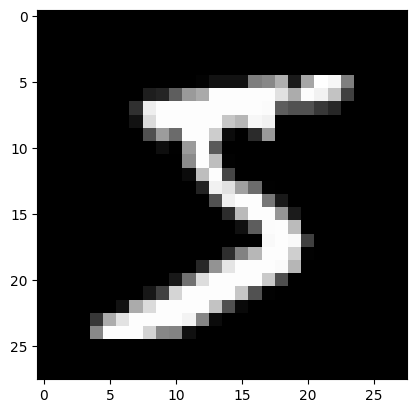

In [14]:
# Import matplotlib.pyplot for visualization
import matplotlib.pyplot as plt
# Import numpy for numerical operations
import numpy as np

# Display the first training image by:
# - Taking the first image (x_train[0])
# - Reshaping it from 1D (784) to 2D (28x28) array
# - Using grayscale colormap
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
# Print the corresponding label (digit) for the first training image
print(y_train[0])

In [15]:
# Import PyTorch library for deep learning operations
import torch

# Convert NumPy arrays to PyTorch tensors
# map() applies torch.tensor to each array (x_train, y_train, x_valid, y_valid)
# This converts our training and validation data from NumPy arrays to PyTorch tensors
# which allows us to use them with PyTorch's deep learning operations
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid))

In [16]:
# Import math module for mathematical operations
import math

# Set random seed for reproducibility (like np.random.seed(0) in numpy)
torch.manual_seed(0)

# Create random weights matrix of shape (784, 10) and normalize by sqrt(784)
# In numpy this would be: weights = np.random.randn(784, 10) / np.sqrt(784)
# The dimensions (784, 10) are used because when we multiply:
# - input data (batch_size=50000, features=784) by
# - weights (features=784, classes=10)
# we get (50000, 10) which gives us predictions for each class.
# Note: If using (10, 784) weights, we'd need to transpose the input
# to (784, 50000) for x * w + b instead of w * x + b
# - 784 is the input size (28x28 pixels flattened)
# - 10 is the output size (digits 0-9)
#
# PyTorch and numpy use different dimension ordering conventions:
# - PyTorch uses (input_size, output_size) for weights
# - Numpy commonly uses (output_size, input_size)
#
# But they represent the same mathematical operation for matrix multiplication

weights = torch.randn(784, 10) / math.sqrt(784)

# Enable gradient tracking for weights - numpy arrays don't have this capability
weights.requires_grad_()

# Create zero vector for biases with gradient tracking enabled
# In numpy this would be: biases = np.zeros(10)
bias = torch.zeros(10, requires_grad=True)

In [17]:
# Define our simple linear model function
# xb: input batch of images (each flattened to 784 pixels)
# Returns: raw logits (pre-softmax scores) for each class
def model(xb):
    # Matrix multiply input (xb) with weights and add bias
    # xb shape: (batch_size, 784)
    # weights shape: (784, 10)
    # bias shape: (10,)
    # Output shape: (batch_size, 10)
    return xb @ weights + bias

In [18]:
# Softmax function converts raw logits to probabilities
# Formula: softmax(x_i) = exp(x_i) / sum(exp(x_j)) for j=1...n
# Where:
# - x_i is the input value for class i
# - exp() is the exponential function
# - sum() is over all classes
#
# For numerical stability, we should subtract max(x) from all values first
# (not implemented here for simplicity)
#
# The function:
# 1. Applies exp() to get positive values
# 2. Normalizes by dividing by sum of all exp values
# 3. Uses unsqueeze(-1) to maintain proper broadcasting
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)


# Cross Entropy Loss Function
# Formula: -1/N * Σ(y_i * log(p_i)) where:
# - N is batch size (number of samples)
# - y_i is target probability (1 for correct class, 0 for others)
# - p_i is predicted probability for class i
# - Σ sums over all classes for each sample, then over all samples
#
# One-hot encoding converts integer class labels to binary vectors:
# e.g. for 10 classes:
# class 3 -> [0,0,0,1,0,0,0,0,0,0]
# class 7 -> [0,0,P0,0,0,0,0,1,0,0]
# This allows element-wise operations with predictions
def cross_entropy_loss(pred, targets):
    # Get batch size (bs) and number of classes (out_features) from prediction shape
    # pred shape: (batch_size, num_classes)
    bs, out_features = pred.shape

    # Convert integer targets to one-hot vectors using identity matrix indexing
    # torch.eye(out_features) creates identity matrix of size (out_features, out_features)
    # Indexing with [targets] selects rows corresponding to target classes
    # Result shape: (batch_size, num_classes)
    one_hot_encoded_targets = torch.eye(out_features)[targets]

    # Calculate cross entropy loss:
    # 1. softmax(pred) converts logits to probabilities
    # 2. .log() takes natural log of probabilities
    # 3. multiply by one-hot targets (zeros out non-target classes)
    # 4. .sum() adds up all values (both across classes and batch)
    # 5. divide by batch size to get average loss per sample
    return -(one_hot_encoded_targets * softmax(pred).log()).sum() / bs


# Accuracy Function - Compares model predictions to actual labels
# Input:
#   pred: Model predictions (logits) with shape (batch_size, num_classes)
#   yb: True labels as integers with shape (batch_size)
# Returns: Boolean tensor indicating correct predictions
def accuracy_func(pred, yb):
    # torch.argmax finds the index of the maximum value along dimension 1 (the class dimension)
    # Example for one sample:
    # pred = [0.1, 0.7, 0.2] (logits/probabilities for 3 classes)
    # argmax returns 1 since 0.7 is the highest value
    #
    # For a batch, if pred is:
    # [[0.1, 0.7, 0.2],
    #  [0.3, 0.2, 0.5]]
    # argmax returns [1, 2] - class 1 for first sample, class 2 for second sample
    pred_class = torch.argmax(pred, dim=1)

    # Compare predicted classes to true labels
    # Example:
    # pred_class = [1, 2]
    # yb =         [1, 1]
    # Returns:     [True, False]
    # True for correct predictions, False for incorrect ones
    # Compare predicted classes (pred_class) with true labels (yb) element-wise
    # (pred_class == yb) creates a boolean tensor: True for correct predictions, False for incorrect
    # .float() converts booleans to 0.0 (False) and 1.0 (True)
    # .mean() calculates the average, giving us the accuracy as a fraction between 0 and 1
    return (pred_class == yb).float().mean()


print(softmax(model(x_train))[0].sum())

tensor(1., grad_fn=<SumBackward0>)


In [19]:
import torch.nn.functional as F

bs = 64

xb = x_train[0:bs]
pred = model(xb)
yb = y_train[0:bs]

print(F.cross_entropy(pred, yb))
print(f"loss={cross_entropy_loss(pred, yb)}")

tensor(2.4608, grad_fn=<NllLossBackward0>)
loss=2.4608447551727295


In [20]:
# Training Configuration
epochs = 2          # Number of complete passes through the training dataset
bs = 64            # Batch size - number of samples processed in each iteration
n = x_train.shape[0]  # Total number of training samples
# Number of batches per epoch (adding 1 to handle remaining samples)
num_batches = n // bs + 1
lr = 0.5          # Learning rate - controls how much we adjust the weights in each step

# Training Loop
# We iterate through the dataset multiple times (epochs) to improve model performance
for epoch in range(epochs):
    for i in range(num_batches):
        # Calculate batch indices
        start_i = i
        end_i = start_i + bs

        # Get current batch of data
        xb = x_train[start_i:end_i]    # Input images (batch_size x 784 pixels)
        yb = y_train[start_i:end_i]    # True labels (batch_size)

        # Forward Pass
        # Model predictions: shape (batch_size x 10)
        pred = model(xb)
        # Example: [[0.1, 0.2, ..., 0.05], ...] for each digit 0-9

        # Calculate Loss and Accuracy
        # Cross Entropy Loss Formula: -Σ(y_true * log(y_pred))
        # For example, if true label is 7:
        # y_true = [0,0,0,0,0,0,0,1,0,0]
        # y_pred = [0.1,0.05,0.1,0.05,0.1,0.1,0.1,0.3,0.05,0.05]
        # loss = -log(0.3) ≈ 1.20
        loss = cross_entropy_loss(pred, yb)

        # Accuracy calculation:
        # 1. Find predicted class (argmax of predictions)
        # 2. Compare with true labels
        # Example: if pred_class=[7,2,1] and true_labels=[7,2,0]
        # accuracy = 2/3 ≈ 0.67 (2 correct predictions out of 3)
        accuracy = accuracy_func(pred, yb)

        # Backward Pass - Compute gradients
        loss.backward()  # Uses autograd to compute ∂loss/∂weights and ∂loss/∂bias

        # Gradient Descent Update
        # Formula: w = w - lr * ∂loss/∂w
        # Example: if weight=0.5, gradient=0.1, lr=0.5
        # New weight = 0.5 - (0.5 * 0.1) = 0.45
        with torch.no_grad():  # Temporarily disable gradient tracking
            weights -= weights.grad * lr  # Update weights
            bias -= bias.grad * lr        # Update bias

            # Reset gradients to zero
            weights.grad.zero_()  # Prevent gradient accumulation
            bias.grad.zero_()

        # Print training progress every 100 batches
        if i % 100 == 0:
            train_loss, train_accuracy = loss.item(), accuracy.item() * 100
            print(f"Loss: {train_loss:6f} Accuracy: {train_accuracy:0.1f}%")

Loss: 2.460845 Accuracy: 4.7%
Loss: 0.117402 Accuracy: 98.4%
Loss: 0.121539 Accuracy: 96.9%
Loss: 0.059987 Accuracy: 100.0%
Loss: 0.080367 Accuracy: 98.4%
Loss: 0.098814 Accuracy: 98.4%
Loss: 0.049722 Accuracy: 100.0%
Loss: 0.079958 Accuracy: 96.9%
Loss: 0.462700 Accuracy: 90.6%
Loss: 0.040384 Accuracy: 100.0%
Loss: 0.070740 Accuracy: 98.4%
Loss: 0.020320 Accuracy: 100.0%
Loss: 0.030883 Accuracy: 100.0%
Loss: 0.033094 Accuracy: 100.0%
Loss: 0.030932 Accuracy: 100.0%
Loss: 0.026909 Accuracy: 100.0%
